### Prereqs (setup, subsampled data, dual views)

In [3]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
print("✅ setup ready")


✅ setup ready


In [4]:
# === PART 0.B — Load CIFAR-10 & SUBSAMPLE for speed, then prepare two views (LR vs GAN) ===

# 1) Load
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()
y_train_full = y_train_full.flatten()
y_test_full  = y_test_full.flatten()

# 2) Subsample: 1,000 train & 200 test per class (~10k/2k total)
def subsample_by_class(X, y, n_per_class):
    Xs, ys = [], []
    for c in range(10):
        idx = np.where(y==c)[0][:n_per_class]
        Xs.append(X[idx]); ys.append(y[idx])
    return np.concatenate(Xs, axis=0), np.concatenate(ys, axis=0)

X_train, y_train = subsample_by_class(X_train_full, y_train_full, 1000)
X_test,  y_test  = subsample_by_class(X_test_full,  y_test_full,  200)
print("Train:", X_train.shape, y_train.shape, " Test:", X_test.shape, y_test.shape)

# 3) Dual preprocessing
#    (A) LR view: [0,1] -> flatten -> PCA(256)
X_train_lr = (X_train.astype(np.float32)/255.0).reshape(len(X_train), -1)
X_test_lr  = (X_test.astype(np.float32)/255.0 ).reshape(len(X_test),  -1)

pca = PCA(n_components=256, whiten=True, random_state=42)
X_train_lr_pca = pca.fit_transform(X_train_lr)
X_test_lr_pca  = pca.transform(X_test_lr)
print("LR features:", X_train_lr_pca.shape, X_test_lr_pca.shape)

#    (B) GAN view: [-1,1]
X_train_gan = (X_train.astype(np.float32)/127.5) - 1.0
X_test_gan  = (X_test.astype(np.float32)/127.5 ) - 1.0
print("GAN range:", float(X_train_gan.min()), float(X_train_gan.max()))


Train: (10000, 32, 32, 3) (10000,)  Test: (2000, 32, 32, 3) (2000,)
LR features: (10000, 256) (2000, 256)
GAN range: -1.0 1.0


# Part 1 — Discriminative Model (Logistic Regression) + Extensions
#### 1.1 Logistic Regression (baseline) — accuracy & confusion matrix (Required)

C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LR] CIFAR-10 (subsample) test accuracy: 0.3755


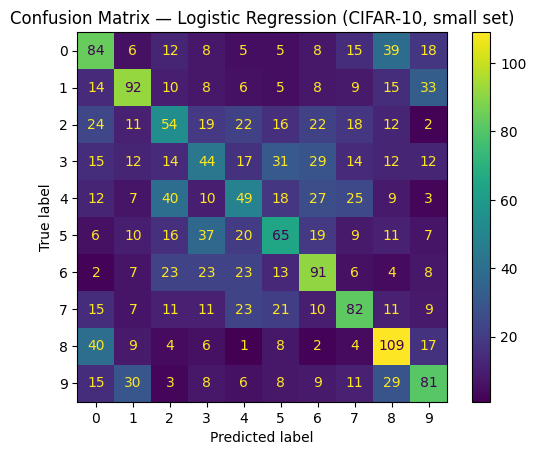


Classification Report (optional):
              precision    recall  f1-score   support

           0       0.37      0.42      0.39       200
           1       0.48      0.46      0.47       200
           2       0.29      0.27      0.28       200
           3       0.25      0.22      0.24       200
           4       0.28      0.24      0.26       200
           5       0.34      0.33      0.33       200
           6       0.40      0.46      0.43       200
           7       0.42      0.41      0.42       200
           8       0.43      0.55      0.48       200
           9       0.43      0.41      0.42       200

    accuracy                           0.38      2000
   macro avg       0.37      0.38      0.37      2000
weighted avg       0.37      0.38      0.37      2000



In [5]:
lr = LogisticRegression(max_iter=2000, multi_class="multinomial", solver="saga", n_jobs=-1)
lr.fit(X_train_lr_pca, y_train)

y_pred = lr.predict(X_test_lr_pca)
lr_acc = accuracy_score(y_test, y_pred)
print(f"[LR] CIFAR-10 (subsample) test accuracy: {lr_acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix — Logistic Regression (CIFAR-10, small set)')
plt.savefig('cifar10_lr_confusion.png', dpi=200, bbox_inches='tight')
plt.show()

print("\nClassification Report (optional):")
print(classification_report(y_test, y_pred))


#### 1.2 Train a Non-linear Classifier (SVM + Decision Tree) — compare vs LR (Required)

In [6]:
# SVM (RBF) on a smaller subset to keep it fast
svm_n = 5000
rng = np.random.default_rng(42)
idx = rng.choice(len(X_train_lr_pca), size=svm_n, replace=False)
svm = SVC(kernel='rbf', C=2.0, gamma='scale')
svm.fit(X_train_lr_pca[idx], y_train[idx])
svm_acc = accuracy_score(y_test, svm.predict(X_test_lr_pca))

# Decision Tree (cap depth to reduce overfitting)
tree = DecisionTreeClassifier(max_depth=30, random_state=42)
tree.fit(X_train_lr_pca, y_train)
tree_acc = accuracy_score(y_test, tree.predict(X_test_lr_pca))

print(f"Compare — LR:{lr_acc:.4f} | SVM:{svm_acc:.4f} | Tree:{tree_acc:.4f}")


Compare — LR:0.3755 | SVM:0.4100 | Tree:0.2100


#### 1.3 Regularization Experiment — L1 vs L2 (Required)

In [7]:
def run_lr_reg(penalty, C=1.0):
    clf = LogisticRegression(max_iter=3000, multi_class="multinomial", solver="saga",
                             penalty=penalty, C=C, n_jobs=-1, random_state=42, tol=1e-3)
    clf.fit(X_train_lr_pca, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_lr_pca))
    return clf, acc

lr_l2, acc_l2 = run_lr_reg("l2", C=1.0)
lr_l1, acc_l1 = run_lr_reg("l1", C=1.0)
print(f"[LR L2] acc={acc_l2:.4f} | [LR L1] acc={acc_l1:.4f}  (C=1.0)")


C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\prashant\tfenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LR L2] acc=0.3755 | [LR L1] acc=0.3750  (C=1.0)


#### 1.4 Feature Importance Visualization — per-class heatmaps (Required)

Back-project LR weights from PCA space → pixel space (32×32).

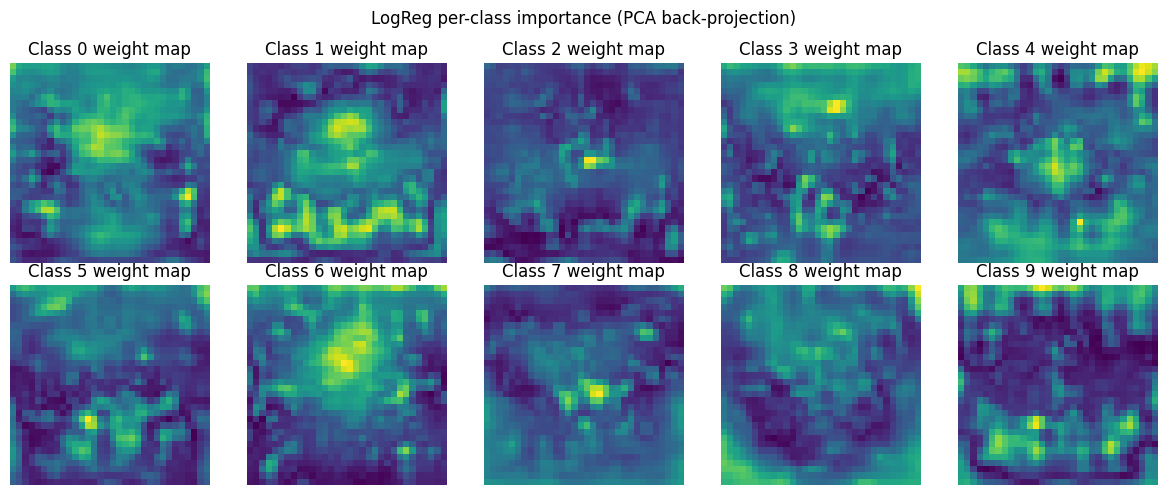

In [8]:
W_pca = lr.coef_                  # (10, 256)
W_pix = W_pca @ pca.components_   # (10, 3072)
W_pix_imgs = W_pix.reshape(10, 32, 32, 3)

# Collapse channels -> single heatmap via abs-sum
W_import = np.abs(W_pix_imgs).sum(axis=-1)  # (10, 32, 32)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()
for c in range(10):
    axes[c].imshow(W_import[c], interpolation='nearest')
    axes[c].set_title(f"Class {c} weight map")
    axes[c].axis('off')
plt.suptitle("LogReg per-class importance (PCA back-projection)")
plt.tight_layout()
plt.savefig('cifar10_lr_importance_maps.png', dpi=200, bbox_inches='tight')
plt.show()


#### 1.5 Cross-Validation — 5-fold (Required)

In [9]:
pipe = Pipeline([
    ("pca", PCA(n_components=256, whiten=True, random_state=42)),
    ("lr", LogisticRegression(max_iter=3000, multi_class="multinomial", solver="saga", n_jobs=-1))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train_lr, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"[LR 5-fold CV] mean={scores.mean():.4f}, std={scores.std():.4f}, scores={np.round(scores,4)}")


[LR 5-fold CV] mean=0.3685, std=0.0136, scores=[0.3855 0.3835 0.3625 0.36   0.351 ]


# Part 2 — Generative Model (GAN) + Extensions
#### 2.0 Build GAN (baseline) — small DCGAN-ish (Required)

In [10]:
latent_dim = 128

def make_generator(g_base=256, use_bn=False):
    G = models.Sequential(name=f"Generator_g{g_base}{'_bn' if use_bn else ''}")
    G.add(layers.Input(shape=(latent_dim,)))
    G.add(layers.Dense(8*8*g_base))
    if use_bn: G.add(layers.BatchNormalization())
    G.add(layers.LeakyReLU(0.2))
    G.add(layers.Reshape((8,8,g_base)))
    G.add(layers.Conv2DTranspose(g_base//2, 4, strides=2, padding='same'))
    if use_bn: G.add(layers.BatchNormalization())
    G.add(layers.LeakyReLU(0.2))
    G.add(layers.Conv2DTranspose(g_base//4, 4, strides=2, padding='same'))
    if use_bn: G.add(layers.BatchNormalization())
    G.add(layers.LeakyReLU(0.2))
    G.add(layers.Conv2D(3, 3, padding='same', activation='tanh'))
    return G

def make_discriminator(d_base=64, drop=0.25, deeper=False):
    D = models.Sequential(name=f"Discriminator_d{d_base}{'_deep' if deeper else ''}")
    D.add(layers.Input(shape=(32,32,3)))
    D.add(layers.Conv2D(d_base,   3, strides=2, padding='same')); D.add(layers.LeakyReLU(0.2)); D.add(layers.Dropout(drop))
    D.add(layers.Conv2D(d_base*2, 3, strides=2, padding='same')); D.add(layers.LeakyReLU(0.2)); D.add(layers.Dropout(drop))
    if deeper:
        D.add(layers.Conv2D(d_base*4, 3, strides=2, padding='same')); D.add(layers.LeakyReLU(0.2)); D.add(layers.Dropout(drop))
    D.add(layers.Flatten())
    D.add(layers.Dense(1, activation='sigmoid'))
    return D

def build_gan(lr_g=1e-4, lr_d=1e-4, g_base=256, d_base=64, use_bn=False, deeper_d=False):
    G = make_generator(g_base=g_base, use_bn=use_bn)
    D = make_discriminator(d_base=d_base, deeper=deeper_d)
    D.compile(optimizer=tf.keras.optimizers.Adam(lr_d), loss='binary_crossentropy')
    z_in = layers.Input(shape=(latent_dim,))
    fake = G(z_in)
    D.trainable = False
    valid = D(fake)
    GAN = models.Model(z_in, valid, name="GAN")
    GAN.compile(optimizer=tf.keras.optimizers.Adam(lr_g), loss='binary_crossentropy')
    return G, D, GAN


#### 2.1 Train GAN + Save Progress & Losses and  2.3 Visualize Training Progress — snapshots every N epochs and 2.4 Plot & Interpret Loss Curves

C:\Users\prashant\tfenv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[gan_base] Epoch 1/10  D:0.7330  G:0.6199
[gan_base] Epoch 2/10  D:0.8436  G:0.4776


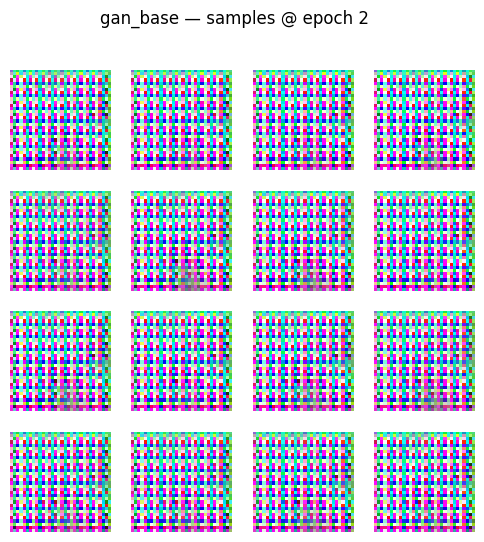

[gan_base] Epoch 3/10  D:0.9508  G:0.3866
[gan_base] Epoch 4/10  D:1.0844  G:0.3127


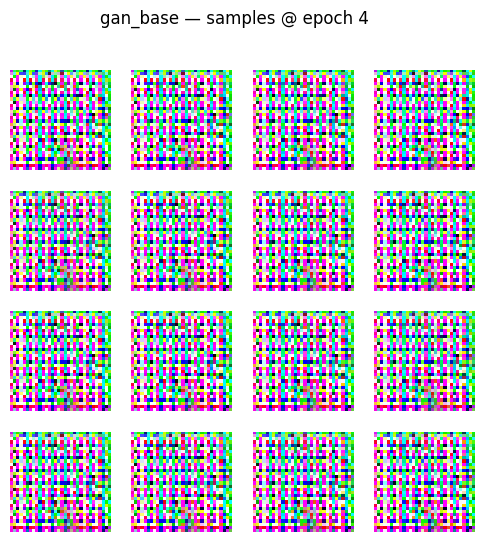

[gan_base] Epoch 5/10  D:1.2165  G:0.2593
[gan_base] Epoch 6/10  D:1.3311  G:0.2215


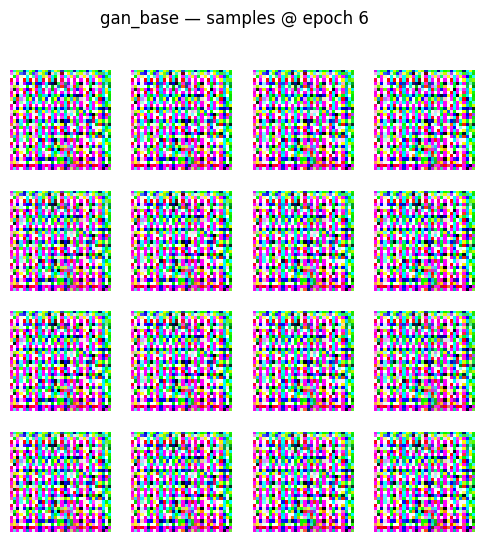

[gan_base] Epoch 7/10  D:1.4299  G:0.1934
[gan_base] Epoch 8/10  D:1.5177  G:0.1718


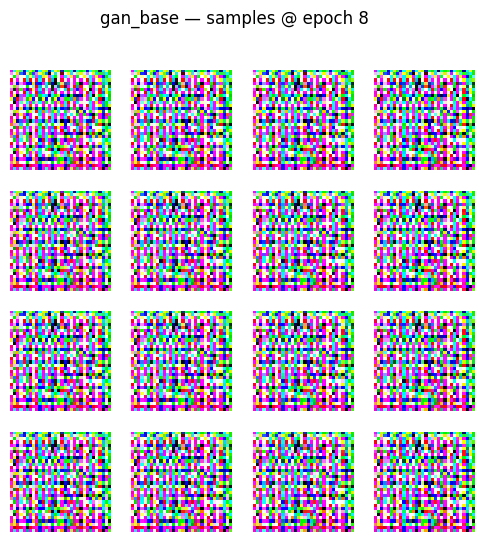

[gan_base] Epoch 9/10  D:1.5963  G:0.1546
[gan_base] Epoch 10/10  D:1.6665  G:0.1406


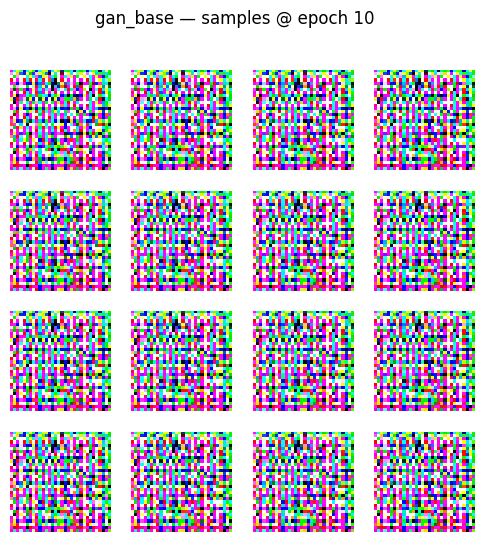

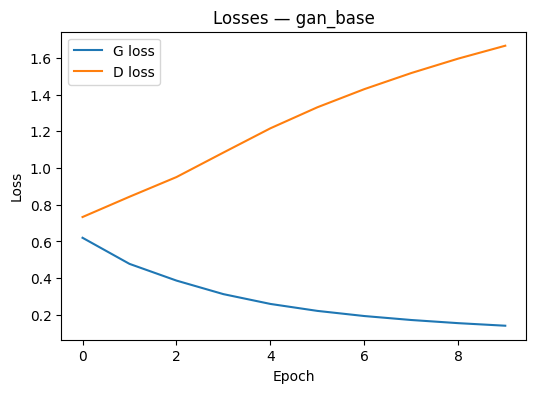

In [11]:
def plot_and_save_grid(imgs, title, path):
    n = imgs.shape[0]; cols = 4; rows = 4
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow((imgs[i]+1)/2); plt.axis('off')
    plt.suptitle(title); plt.savefig(path, dpi=200, bbox_inches='tight'); plt.show()

def train_gan(name, batch_size=128, epochs=10, lr_g=1e-4, lr_d=1e-4,
              g_base=256, d_base=64, use_bn=False, deeper_d=False, snapshot_every=1):
    G, D, GAN = build_gan(lr_g, lr_d, g_base, d_base, use_bn, deeper_d)
    steps_per_epoch = X_train_gan.shape[0] // batch_size
    fixed_noise = tf.random.normal([16, latent_dim])
    g_hist, d_hist = [], []

    for epoch in range(1, epochs+1):
        idx = np.random.permutation(X_train_gan.shape[0]); X_shuf = X_train_gan[idx]
        d_losses, g_losses = [], []

        for step in range(steps_per_epoch):
            real = X_shuf[step*batch_size:(step+1)*batch_size]
            z = tf.random.normal([batch_size, latent_dim]); fake = G.predict(z, verbose=0)
            y_real = np.ones((batch_size,1), np.float32); y_fake = np.zeros((batch_size,1), np.float32)
            d_loss = 0.5*(D.train_on_batch(real, y_real) + D.train_on_batch(fake, y_fake))
            g_loss = GAN.train_on_batch(tf.random.normal([batch_size, latent_dim]),
                                        np.ones((batch_size,1), np.float32))
            d_losses.append(float(d_loss)); g_losses.append(float(g_loss))

        d_hist.append(np.mean(d_losses)); g_hist.append(np.mean(g_losses))
        print(f"[{name}] Epoch {epoch}/{epochs}  D:{d_hist[-1]:.4f}  G:{g_hist[-1]:.4f}")

        if epoch % snapshot_every == 0:
            samples = G.predict(fixed_noise, verbose=0)
            plot_and_save_grid(samples, f"{name} — samples @ epoch {epoch}", f'{name}_epoch_{epoch}.png')

    plt.figure(figsize=(6,4))
    plt.plot(g_hist, label='G loss'); plt.plot(d_hist, label='D loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Losses — {name}')
    plt.legend(); plt.savefig(f'{name}_losses.png', dpi=200, bbox_inches='tight'); plt.show()
    return {"name": name, "g_hist": g_hist, "d_hist": d_hist}

# === Baseline quick run (fast) ===
baseline_hist = train_gan(name="gan_base", batch_size=128, epochs=10, lr_g=1e-4, lr_d=1e-4,
                          g_base=256, d_base=64, use_bn=False, deeper_d=False, snapshot_every=2)


#### 2.2 Hyperparameter Sensitivity — vary batch size / learning rate / capacity (Required)

[gan_b64_lr2e-4] Epoch 1/8  D:0.9045  G:0.4131


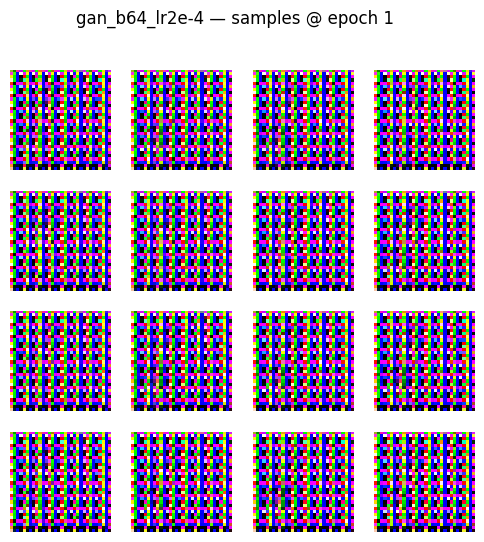

[gan_b64_lr2e-4] Epoch 2/8  D:1.2251  G:0.2199


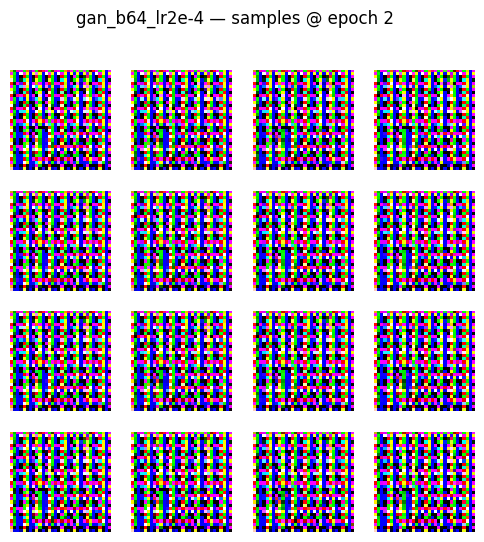

[gan_b64_lr2e-4] Epoch 3/8  D:1.4571  G:0.1524


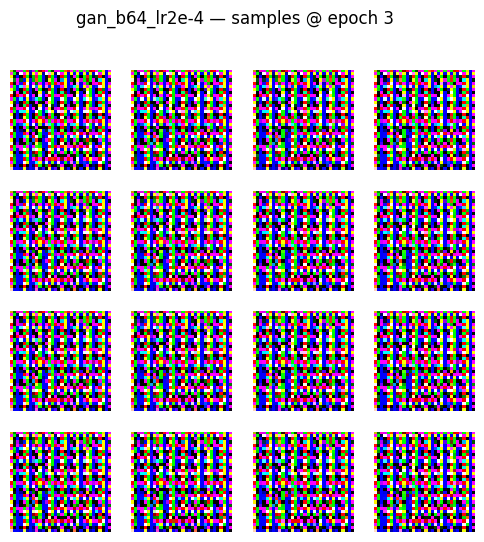

[gan_b64_lr2e-4] Epoch 4/8  D:1.6178  G:0.1184


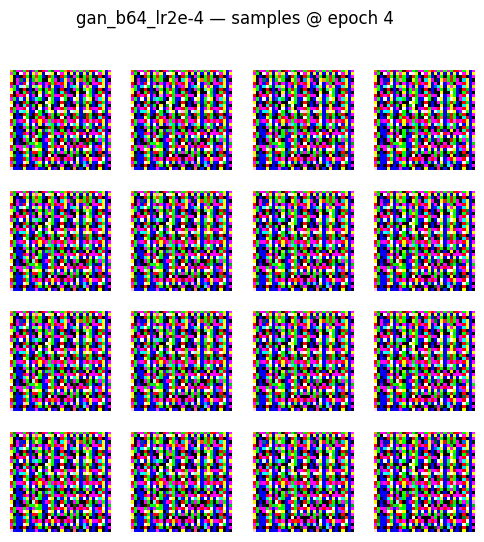

In [ ]:
# Two tiny comparison runs (fast)
hist_b64  = train_gan(name="gan_b64_lr2e-4",  batch_size=64,  epochs=8, lr_g=2e-4, lr_d=2e-4,  g_base=256, d_base=64)
hist_b256 = train_gan(name="gan_b256_lr5e-5", batch_size=256, epochs=8, lr_g=5e-5, lr_d=5e-5, g_base=256, d_base=64)


#### 2.5 Mode Collapse Experiment — intentionally unstable config (Required)

[gan_collapse] Epoch 1/6  D:1.4648  G:0.1661


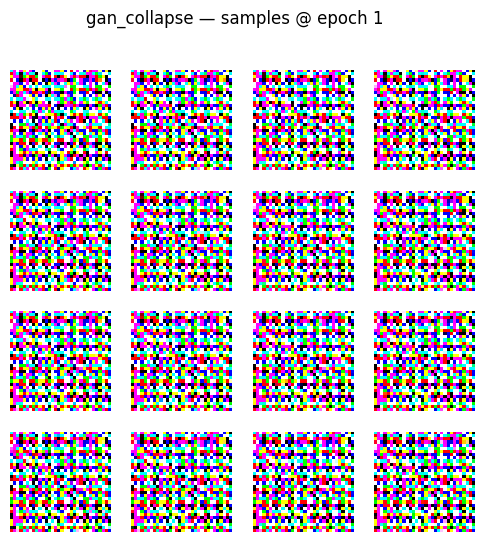

[gan_collapse] Epoch 2/6  D:2.0597  G:0.0575


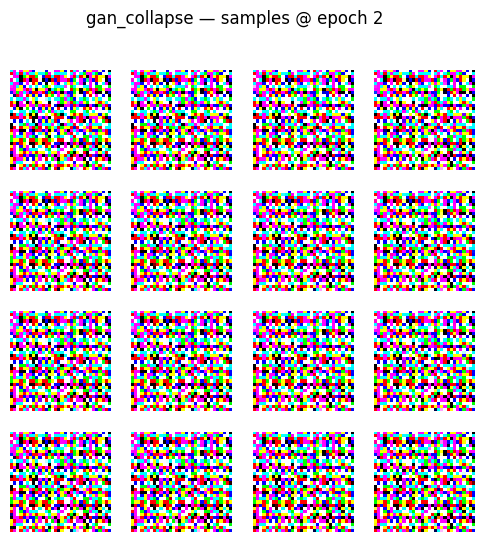

[gan_collapse] Epoch 3/6  D:2.2934  G:0.0380


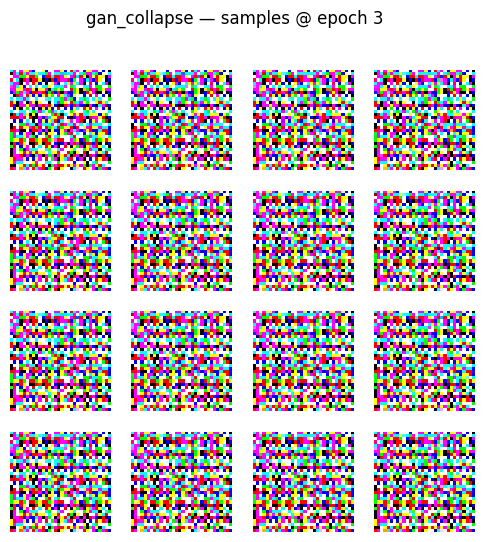

[gan_collapse] Epoch 4/6  D:2.4187  G:0.0294


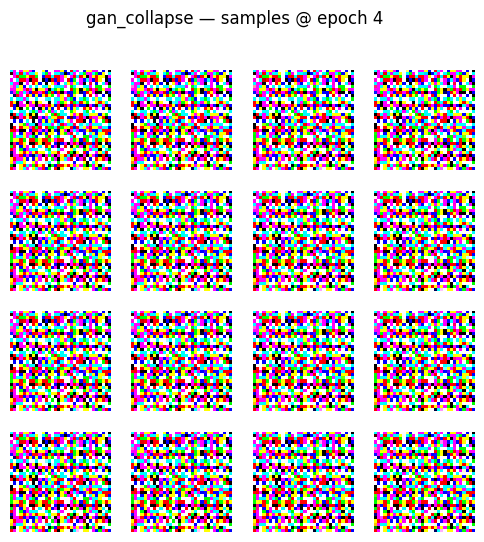

[gan_collapse] Epoch 5/6  D:2.4961  G:0.0246


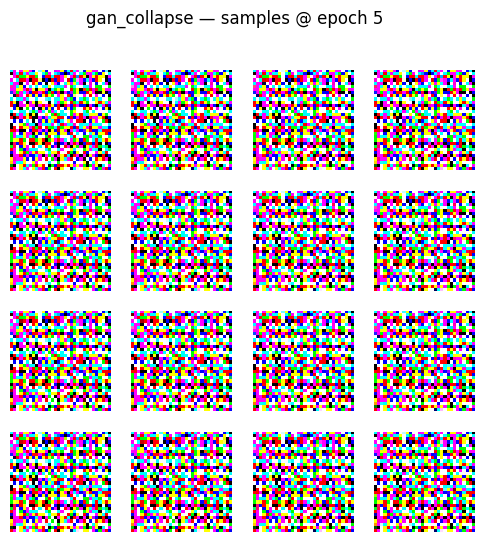

[gan_collapse] Epoch 6/6  D:2.5565  G:0.0214


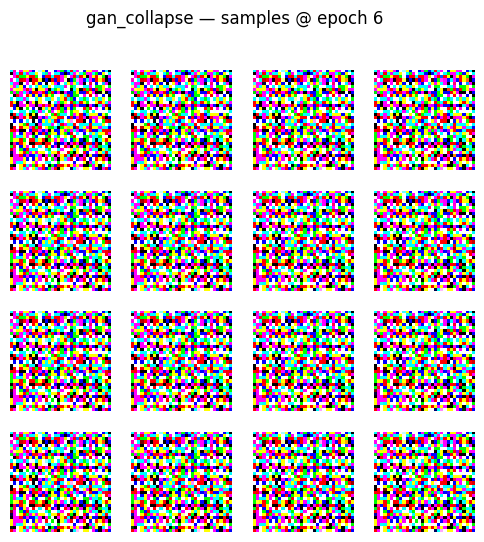

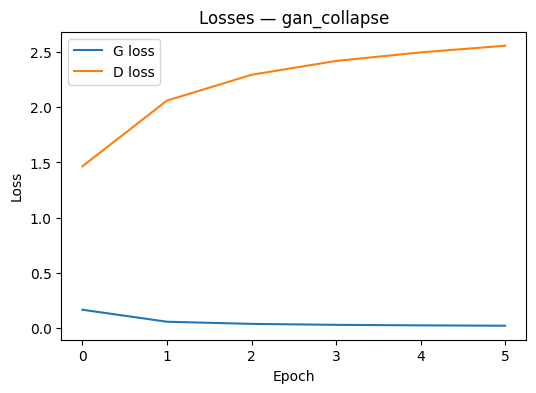

In [15]:
# Very unstable: tiny batch, G lr >> D lr
hist_collapse = train_gan(name="gan_collapse", batch_size=32, epochs=6, lr_g=2e-3, lr_d=5e-5,
                          g_base=256, d_base=64, use_bn=False, deeper_d=False)
# In your report: note repeated/near-identical samples & odd loss behavior.


#### 2.6 Modify GAN Architecture — add BatchNorm / deeper D (Required)

[gan_arch_v2] Epoch 1/8  D:0.6940  G:0.5072


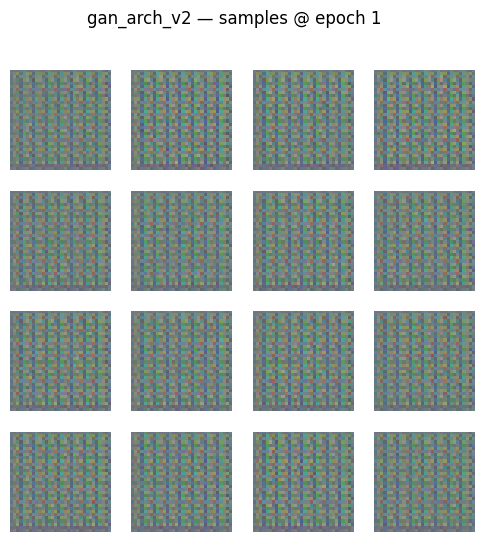

[gan_arch_v2] Epoch 2/8  D:0.7107  G:0.4099


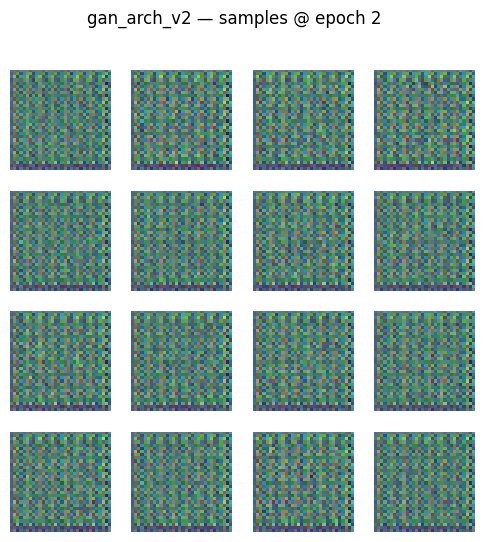

[gan_arch_v2] Epoch 3/8  D:0.7303  G:0.3588


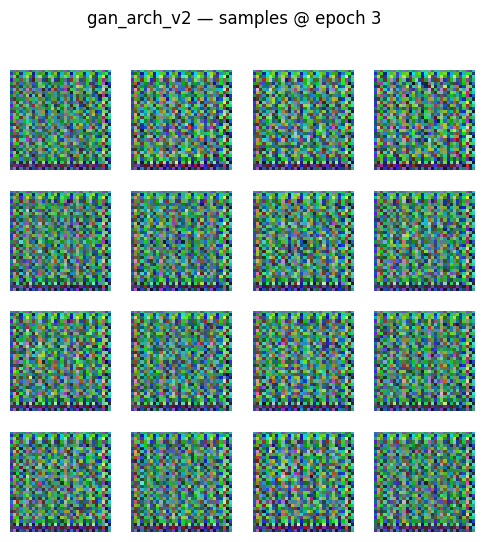

[gan_arch_v2] Epoch 4/8  D:0.7693  G:0.3189


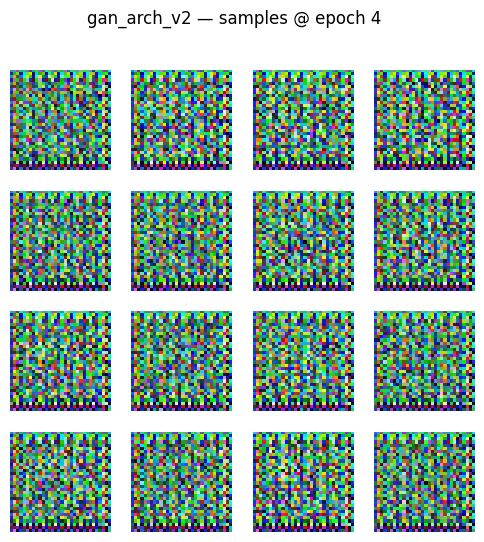

[gan_arch_v2] Epoch 5/8  D:0.8316  G:0.2877


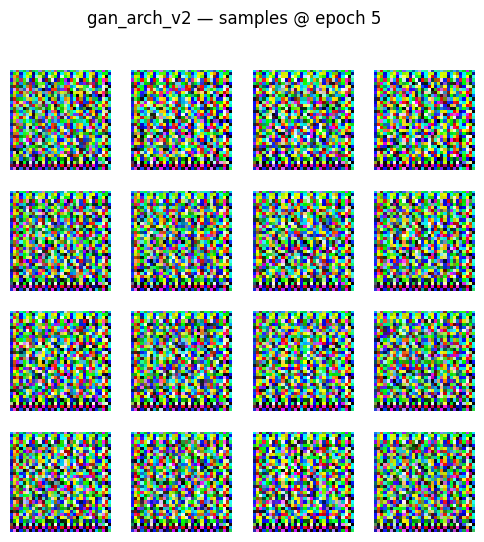

[gan_arch_v2] Epoch 6/8  D:0.9043  G:0.2627


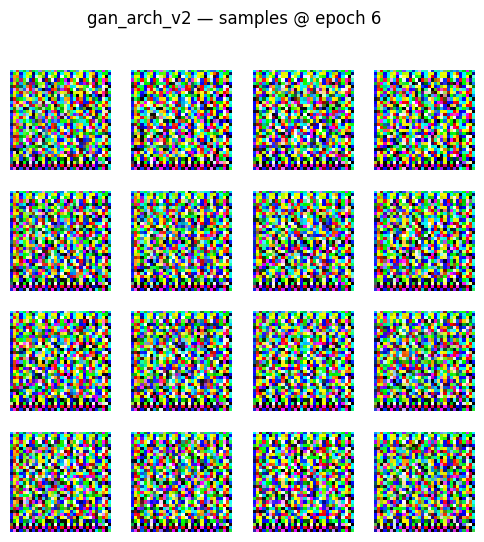

[gan_arch_v2] Epoch 7/8  D:0.9738  G:0.2423


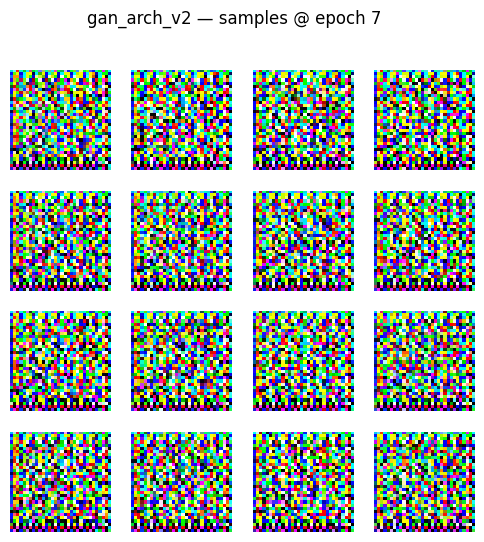

[gan_arch_v2] Epoch 8/8  D:1.0352  G:0.2254


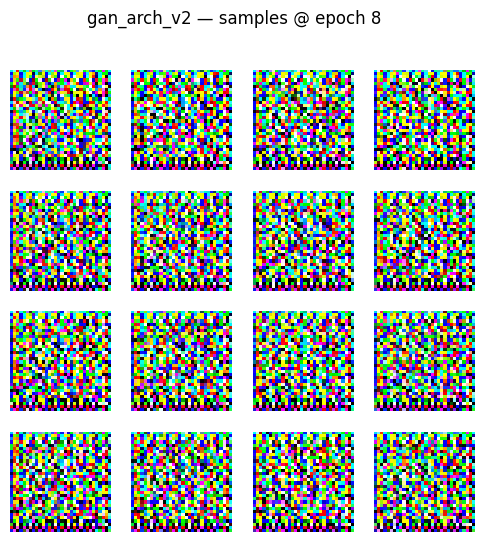

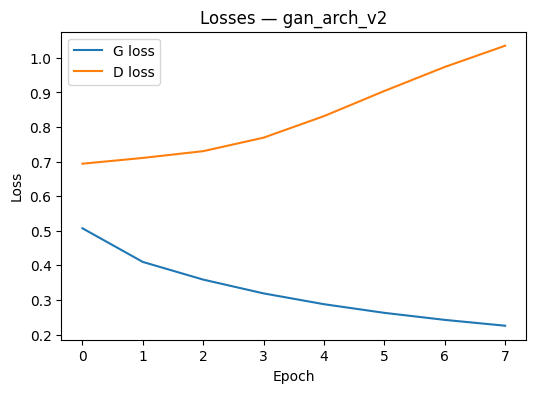

In [16]:
# Architecture variant: BatchNorm in G + deeper D for capacity/regularization
hist_arch = train_gan(name="gan_arch_v2", batch_size=128, epochs=8, lr_g=1e-4, lr_d=1e-4,
                      g_base=256, d_base=64, use_bn=True, deeper_d=True)
# In your report: compare visuals and losses vs baseline.


In [1]:
def interpolate_latent(G, z_a=None, z_b=None, steps=10, save_path="interpolation.png"):
    if z_a is None:
        z_a = tf.random.normal([1, latent_dim])
    if z_b is None:
        z_b = tf.random.normal([1, latent_dim])

    # Linearly interpolate
    ratios = np.linspace(0, 1, steps)
    z_interp = np.array([(1-r)*z_a + r*z_b for r in ratios])
    
    # Generate images
    imgs = G.predict(z_interp, verbose=0)
    
    # Plot in a strip
    plt.figure(figsize=(2*steps, 2))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow((imgs[i]+1)/2)   # scale from [-1,1] to [0,1]
        plt.axis('off')
    plt.suptitle("Latent Interpolation")
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


In [ ]:
interpolate_latent(G, steps=8)
